In [121]:
include("MySimplexQuad.jl")
using .MySimplexQuad

include("OrthoPols.jl")
using .OrthoPols

###############################################################

function rse(vec::Vector{T}) where T <: AbstractFloat
    threshold = if T == BigFloat
        BigFloat("1e-60")
    else
        T(1e-14)
    end
    
    map(x -> abs(x) < threshold ? zero(T) : x, vec)
end

###############################################################

rse (generic function with 1 method)

In [122]:
X, W = mysimplexquad(BigFloat, 10, 2)

(BigFloat[0.02963725131430515645619495295877175604125123227075814496704810230821749590071015 0.9699709678385135029569356423655920593053451564625792084689040051698797214285052; 0.09700666144126664671986133050959620372080015895230291710898491215825785140834879 0.9017109877901467703487989784097679814681176760729360475326567373055975858521348; … ; 0.01224133371286300483276998896271471495776295624877359591795950527537862041894788 0.06173207187714812552262936719425014145287208036190213218470079750300542267782672; 0.01289124978829308614488743894070628427028829731577820725603243580057175860543945 0.01191761343241559690974558695898597603002784725837485802027599304441351971792659], BigFloat[4.99748596350854223023038927947704888290922496076865170291017745075968709338121e-05, 0.0002806636840481107890717376405293703516628530540470277659454775298043531421226195, 0.0007592063141351028941095515357248049088664844205130134562227061108455611711563956, 0.001446831722862298548762548634043654769547814318039

In [123]:
# order = 10
# z0 = [0.0, 0.0]
# z1 = [1.0, 0.0]
# z2 = [0.0, 1.0]

# # z0 = BigFloat.([0, 0])
# # z1 = BigFloat.([1, 0])
# # z2 = BigFloat.([0, 1])

# use_bigfloat = true
# p1 = use_bigfloat ? BigFloat[0.0, 0.0] : [0.0, 0.0]
# p2 = use_bigfloat ? BigFloat[1.0, 0.0] : [1.0, 0.0]
# p3 = use_bigfloat ? BigFloat[0.0, 1.0] : [0.0, 1.0]

# T1 = hcat(p1, p2, p3)

# pols0, dersx0, dersy0 = ortho2eva3(1, p1)
# dersy0

# # eval_T1 = rse(ortho2eva3(order, T1[:,1])[1])
# # eval_T1

# pols0 = ortho2eva3(order, X[2,:])[1]

In [124]:
using LinearAlgebra
using Optim
using Plots
using Optim
using LineSearches


freeparam = 8
order = 8
use_bigfloat = true

pols0, dersx0, dersy0 = ortho2eva3(10, z0)

###############################################################

function rse(vec::Vector{T}) where T <: AbstractFloat
    threshold = if T == BigFloat
        BigFloat("1e-60")
    else
        T(1e-14)
    end
    
    map(x -> abs(x) < threshold ? zero(T) : x, vec)
end

###############################################################
p1 = use_bigfloat ? BigFloat[0.0, 0.0] : [0.0, 0.0]
p2 = use_bigfloat ? BigFloat[1.0, 0.0] : [1.0, 0.0]
p3 = use_bigfloat ? BigFloat[0.0, 1.0] : [0.0, 1.0]

m1 = (p2 .+ p3) ./ (use_bigfloat ? BigFloat(2.0) : 2.0)
m2 = (p1 .+ p3) ./ (use_bigfloat ? BigFloat(2.0) : 2.0)
m3 = (p1 .+ p2) ./ (use_bigfloat ? BigFloat(2.0) : 2.0)

b = (p1 .+ p2 .+ p3) ./ (use_bigfloat ? BigFloat(3.0) : 3.0)
###############################################################


# vertices
T1 = hcat(p1, p2, p3)
eval_T1(order) = rse(ortho2eva3(order, T1[:,1])[1])

# edge midpoints
T2 = hcat(m1, m2, m3)
eval_T2(order) = rse(ortho2eva3(order, T2[:,1])[1])

# midpoint
T3 = hcat(b)
eval_T3(order) = rse(ortho2eva3(order, T3[:,1])[1])


# edge class
T4(a) = hcat(a * p1 .+ (1 .- a) * p2,
             a * p2 .+ (1 .- a) * p1,
             a * p3 .+ (1 .- a) * p1,
             a * p1 .+ (1 .- a) * p3,
             a * p3 .+ (1 .- a) * p2,
             a * p2 .+ (1 .- a) * p3)

eval_T4(order,a) = rse(ortho2eva3(order, T4(a)[:,1])[1])


# inner class, type 1
T5(a) = hcat(a * m1 .+ (1 .- a) * p1, 
             a * m2 .+ (1 .- a) * p2, 
             a * m3 .+ (1 .- a) * p3)

eval_T5(order,a) = rse(ortho2eva3(order, T5(a)[:,1])[1])


# inner class, type 2
T6(a, b) =  hcat(b * (a * m1 .+ (1 - a) .* p1) .+ (1 - b) * (a * m2 .+ (1 - a) .* p2),
                 b * (a * m1 .+ (1 - a) .* p1) .+ (1 - b) * (a * m3 .+ (1 - a) .* p3),
                 b * (a * m3 .+ (1 - a) .* p3) .+ (1 - b) * (a * m2 .+ (1 - a) .* p2),
                 b * (a * m2 .+ (1 - a) .* p2) .+ (1 - b) * (a * m1 .+ (1 - a) .* p1),
                 b * (a * m3 .+ (1 - a) .* p3) .+ (1 - b) * (a * m1 .+ (1 - a) .* p1),
                 b * (a * m2 .+ (1 - a) .* p2) .+ (1 - b) * (a * m3 .+ (1 - a) .* p3))

eval_T6(order,a,b) = rse(ortho2eva3(order, T6(a, b)[:,1])[1])



# System setup
function A(a,order)
    hcat(
        eval_T1(order), # trig vertices
        # eval_T2, # edge midpoints

        eval_T4(order,a[1]), # edge class
        eval_T4(order,a[2]), # edge class
        


        # eval_T3, # trig midpoint
        
        eval_T5(order,a[3]),
        eval_T5(order,a[4]),
        eval_T5(order,a[5]),

        eval_T6(order,a[6],a[7]),
        # eval_T5(order,a[8]),
        )'
end


# # # System setup
# # function Aij(i, j, a)
# #     vcat(sum(eval_T1(i, j)),
# #          sum(eval_T4(a[1], i, j)), # edge class
# #          sum(eval_T5(a[2], i, j)),
# #          sum(eval_T5(a[3], i, j)))
# # end

# # A(a, order) = hcat([Aij(i, j, a) for i in 0:order for j in 0:order if i + j <= order]...)
# rhs(order) = vcat([integral(i, j) for i in 0:order for j in 0:order if i + j <= order]...)



function rhs(::Type{T}, order::Int) where T <: AbstractFloat
    X, W = mysimplexquad(T, order, 2)
    w = zeros(T, div((order + 1) * (order + 2), 2))  # Initialize w with the correct type and size
    
    for k = 1:length(W)
        pols = ortho2eva3(order, T.(X[k,:]))[1]
        w .+= W[k] .* pols
    end
    
    return w
end

# integral2(1,2)

# rhs2(order) = vcat([integral2(i, j) for i in 0:order for j in 0:order if i + j <= order]...)
# rhs2(5)

rhs(BigFloat, order)

45-element Vector{BigFloat}:
  0.3799178428257962736655938753272726676983867244436551593056443268501611165855502
  0.3102016197006998663137395823277446959170680752258841250313255036929878046653268
  0.3102016197006998663137395823277446959170680752258841250313255036929878046653311
  0.1887826938719025023101990554323129359537457875846039933976282746969749886289174
  0.5274606479156334451143998547592232482906054392553163930229134384409129933897957
 -0.1688523745892427882958195001454545189770607664194022930247308119334049407046919
  0.2157817665293536959979137960679509633516860399506687758401313327243339519603005
  0.4513923262803010677806767281350197067347332612953536553957068713001702906256294
  0.141262325530293118564300390684613100956796336927949743954458360712230003252915
 -0.1726226960401815407743964742104932525999029573003059682190021943186786012814451
  ⋮
  1.33096096946446946277568735843327805624074446598216244269837288407164892861757
  5.316488854946690501142716974467316515139226

In [125]:
A([0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1],2)
# eval_T6(0.3,0.6)

7×6 adjoint(::Matrix{BigFloat}) with eltype BigFloat:
 0.759836  0.0        0.0        -0.653962  0.0        -0.731152
 0.759836  1.67509    0.0         2.92158   1.3677     -0.731152
 0.759836  1.67509    0.0         2.92158   1.3677     -0.731152
 0.759836  0.0930605  0.0930605  -0.587518  0.0924345  -0.770841
 0.759836  0.0930605  0.0930605  -0.587518  0.0924345  -0.770841
 0.759836  0.0930605  0.0930605  -0.587518  0.0924345  -0.770841
 0.759836  1.51689    0.0930605   2.3335    1.50668    -0.770841

In [126]:

# f(a) = A(a,order)'*((A(a,order) * A(a,order)')\(A(a,order) * rhs(order)))-rhs(order)
f(a) = norm(A(a,order)'*((A(a,order) * A(a,order)')\(A(a,order) * rhs(BigFloat,order)))-rhs(BigFloat,order))

f (generic function with 1 method)

In [127]:
f([0.3, 0.23, 0.85, 0.23, 0.31, 0.21, 0.32, 0.2])

2.528675602326702278850993520882228447058805572273903636179578236842993232870545

BigFloat[0.723171770734230947849460620763664146529757478146058937340775519576896446238834, 0.2702555937746091242782095868202866118921613319597400252258871363245096297589498, 0.6974252021568776701771595635801993714527927529710902294106313493299298400529551, 0.1712558738021600788063765639941033248462909473906029700859436149321113340704414, 0.7056742396027321376186084527396592426772799951652089272220372403662813631797235, 0.3837844673708421990197954030244087799046272638732569342782561475774238957114903, 0.4967941258377132131931395267726893075397785486476265704277921518919325372110052, 0.3579255786832030640437922308192673535045135143456042862275247274858602786196116]

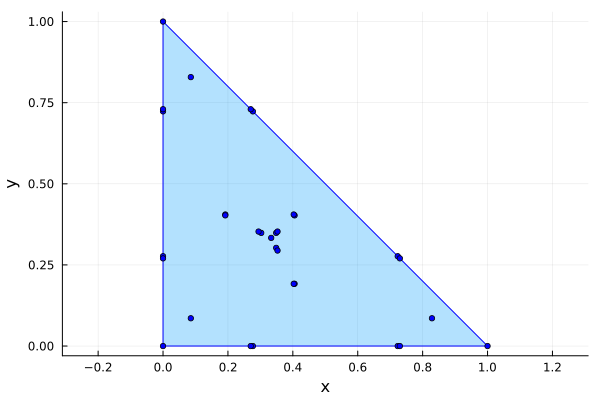

In [128]:
# Define the bounds
# lower_bounds = BigFloat[0.0, 0.0, 0.0]
# upper_bounds = BigFloat[1, 1, 1]
# initial_value = BigFloat[0.1, 0.1, 0.2]

min_val = 0.15
max_val = 0.85
a = min_val .+ (max_val - min_val) .* (use_bigfloat ? BigFloat.(rand(freeparam)) : rand(freeparam))

# a = BigFloat[0.01, 0.01, 0.02]
# a = BigFloat[0.1, 0.1, 0.2] # works!
# a = BigFloat[0.3, 0.23, 0.85, 0.23, 0.31, 0.21, 0.32] #works!
# a = BigFloat[0.3, 0.23, 0.85, 0.23, 0.31, 0.21, 0.32]

print(a)

#########################################################################################################################
# Plotting initial distribution
#########################################################################################################################
using Plots
plot()
# gr()  # Set the backend to GR

# Define the vertices of the triangle
x = [p1[1], p2[1], p3[1], p1[1]]
y = [p1[2], p2[2], p3[2], p1[2]]

# Plot the triangle
plot!(x, y, seriestype = :shape, fillalpha = 0.3, linecolor = :blue, legend = false, aspect_ratio = :equal)

scatter!(T1[1, :], T1[2, :], markersize = 3, markercolor = :blue, legend = false, aspect_ratio = :equal)
scatter!(T3[1, :], T3[2, :], markersize = 3, markercolor = :blue, legend = false, aspect_ratio = :equal)

scatter!(T4(a[1])[1, :], T4(a[1])[2, :], markersize = 3, markercolor = :blue, legend = false, aspect_ratio = :equal)
scatter!(T4(a[2])[1, :], T4(a[2])[2, :], markersize = 3, markercolor = :blue, legend = false, aspect_ratio = :equal)

scatter!(T5(a[3])[1, :], T5(a[3])[2, :], markersize = 3, markercolor = :blue, legend = false, aspect_ratio = :equal)
scatter!(T5(a[4])[1, :], T5(a[4])[2, :], markersize = 3, markercolor = :blue, legend = false, aspect_ratio = :equal)
scatter!(T5(a[5])[1, :], T5(a[5])[2, :], markersize = 3, markercolor = :blue, legend = false, aspect_ratio = :equal)

scatter!(T6(a[6],a[7])[1, :], T6(a[6],a[7])[2, :], markersize = 3, markercolor = :blue, legend = false, aspect_ratio = :equal)

# Add plot title and labels
xlabel!("x")
ylabel!("y")
#########################################################################################################################

In [129]:
# Initialize an array of strings
# bigfloat_strings = [
#     "0.3497563276590531286006952954445668121161354629231253675436650998033682105163362",
#     "0.1168256301165253085822263078463557402695806217250798718929824146309700850615156",
#     "0.5359920624522696018750290486301153617643693213794692184596278721041560647158745",
#     "0.9164715952736393185489606854094341672897032003628564147678514037992402493209116",
#     "0.1285678358785933850614611990426681246047116310691077189241495441532828989922064",
#     "0.1855704466508220428127271513465450386606911784968365895779597754013640528697462",
#     "0.1423596791302088104796922427088486702578148291092101059677756895056200393064595",
#     "0.7432798925094192858277743305767780573199273721370474792622147549960748094153323",
#     "0.2656623668160845723068798650918091304937794310308354680743438212151354872098177",
# ]
# print(a)
# Convert each string to BigFloat with full precision
# a = [parse(BigFloat, x) for x in bigfloat_strings]
# f(a)

# 0.435550025252798077216426997182572878840986513981683599296083745679164511699355
# 0.6637731214588893098777332609060568543103149065899114560422128146835452078278195
# 0.3264161593786625458414059141416173085535859770832105718160910797984164410934227
# 0.3238553555448429211620722851576776397156578278747866410510017646726121931521902
# 0.5240811779919137310112339080707195055864630881706360421103444401091930870961733
# 0.3802763277282470564714697017139324236356332292701035679786790042952726587088819
# 0.3395063654849585434670365174169452616756157045808562770409328931964232367590739

a

8-element Vector{BigFloat}:
 0.723171770734230947849460620763664146529757478146058937340775519576896446238834
 0.2702555937746091242782095868202866118921613319597400252258871363245096297589498
 0.6974252021568776701771595635801993714527927529710902294106313493299298400529551
 0.1712558738021600788063765639941033248462909473906029700859436149321113340704414
 0.7056742396027321376186084527396592426772799951652089272220372403662813631797235
 0.3837844673708421990197954030244087799046272638732569342782561475774238957114903
 0.4967941258377132131931395267726893075397785486476265704277921518919325372110052
 0.3579255786832030640437922308192673535045135143456042862275247274858602786196116

In [130]:
# println(a)

# td = TwiceDifferentiable(f, a; autodiff = :forward);

# # result = optimize(td, a, Newton(; linesearch = LineSearches.MoreThuente()), Optim.Options(g_tol = 1e-100, iterations = 1000, show_trace = true, show_every = 1, time_limit = 1000))
# # result = optimize(td, a, Newton(; linesearch = LineSearches.BackTracking(), alphaguess = LineSearches.InitialStatic()), Optim.Options(g_tol = 1e-15, iterations = 1000, show_trace = true, show_every = 1, time_limit = 1000))

# result = optimize(td, a, Newton(; linesearch = LineSearches.BackTracking(), alphaguess = LineSearches.InitialStatic()), Optim.Options(g_tol = 1e-63, iterations = 50, show_trace = true, show_every = 10, time_limit = 1000))

# println(result)

# a = Optim.minimizer(result)
# using Base.Threads

# using Distributed

# num_runs = 5

# @threads  for i in 1:num_runs
# a = min_val .+ (max_val - min_val) .* BigFloat.(rand(freeparam))



# of = TwiceDifferentiable(f, a; autodiff = :forward)
# # method = Newton(; linesearch = LineSearches.MoreThuente())
# method = Newton(; linesearch = LineSearches.BackTracking())


of = OnceDifferentiable(f, a; autodiff = :forward);
method = Fminbox(GradientDescent())

options = Optim.Options(g_tol = 1e-20, iterations = 200, show_trace = true, show_every = 10, time_limit = 1000)


# lower_bounds = fill(BigFloat("0"), freeparam)
# upper_bounds = fill(Inf, freeparam)

result = optimize(of, a, method, options)
# result = optimize(of,lower_bounds, upper_bounds, a, method, options)
a = Optim.minimizer(result)
# # end

print(a)

MethodError: MethodError: no method matching initial_state(::Fminbox{GradientDescent{InitialPrevious{Float64}, HagerZhang{Float64, Base.RefValue{Bool}}, Nothing, Optim.var"#13#15"}, Float64, Optim.var"#51#53"}, ::Optim.Options{Float64, Nothing}, ::OnceDifferentiable{BigFloat, Vector{BigFloat}, Vector{BigFloat}}, ::Vector{BigFloat})

Closest candidates are:
  initial_state(!Matched::Optim.KrylovTrustRegion, ::Any, ::Any, ::Array{T}) where T
   @ Optim C:\Users\Radu\.julia\packages\Optim\ZhuZN\src\multivariate\solvers\second_order\krylov_trust_region.jl:39
  initial_state(!Matched::AcceleratedGradientDescent, ::Any, ::Any, ::AbstractArray{T}) where T
   @ Optim C:\Users\Radu\.julia\packages\Optim\ZhuZN\src\multivariate\solvers\first_order\accelerated_gradient_descent.jl:35
  initial_state(!Matched::SimulatedAnnealing, ::Any, ::Any, ::AbstractArray{T}) where T
   @ Optim C:\Users\Radu\.julia\packages\Optim\ZhuZN\src\multivariate\solvers\zeroth_order\simulated_annealing.jl:62
  ...


In [131]:
result

UndefVarError: UndefVarError: `result` not defined

In [132]:
# result2 = optimize(f,
#             a,
#             NelderMead(),
#             autodiff = :forward,
#             Optim.Options(g_tol = 1e-63, iterations = 1000, show_trace = true, show_every = 100, time_limit = 1000))

In [133]:
a = Optim.minimizer(result)

UndefVarError: UndefVarError: `result` not defined

In [134]:
(A(a,order) * A(a,order)')\(A(a,order) * rhs(order))

7-element Vector{BigFloat}:
  0.02684641541162104975718180830978749296577918382393629847215794813223609621066332
  0.03024193592211697673737674958344565521359402270266122527914291522013296474777355
  0.003020291657055884764827070546813308411413023601245262105607858697288637602793797
 -0.3765749525577695308797565991488375160461884052400893605167130921459841355197734
  0.01377117364105047559127472989989150682563928281421946042296390863071852061733606
  0.3741971525476500762954146134252645510513242670241672753772086978336518646470782
  0.03977753249866829974791150289571916632544495819789623203986459671903793056309427

In [135]:
f(a)

4.620588319361094842856372166815867368427067431465130248723140941110726280328091

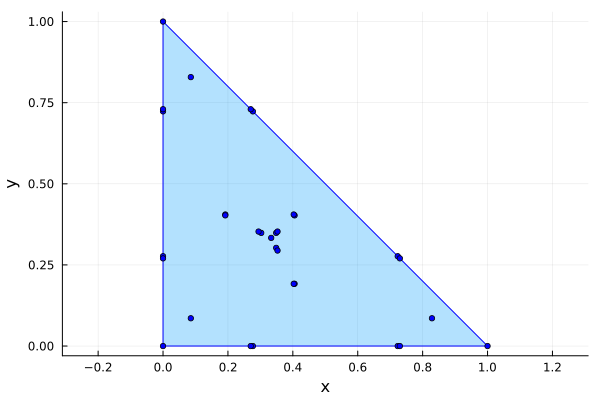

In [136]:
using Plots
# gr()  # Set the backend to GR
plot()
# Define the vertices of the triangle
x = [p1[1], p2[1], p3[1], p1[1]]
y = [p1[2], p2[2], p3[2], p1[2]]

# Plot the triangle
plot!(x, y, seriestype = :shape, fillalpha = 0.3, linecolor = :blue, legend = false, aspect_ratio = :equal)

scatter!(T1[1, :], T1[2, :], markersize = 3, markercolor = :blue, legend = false, aspect_ratio = :equal)
scatter!(T3[1, :], T3[2, :], markersize = 3, markercolor = :blue, legend = false, aspect_ratio = :equal)

scatter!(T4(a[1])[1, :], T4(a[1])[2, :], markersize = 3, markercolor = :blue, legend = false, aspect_ratio = :equal)
scatter!(T4(a[2])[1, :], T4(a[2])[2, :], markersize = 3, markercolor = :blue, legend = false, aspect_ratio = :equal)

scatter!(T5(a[3])[1, :], T5(a[3])[2, :], markersize = 3, markercolor = :blue, legend = false, aspect_ratio = :equal)
scatter!(T5(a[4])[1, :], T5(a[4])[2, :], markersize = 3, markercolor = :blue, legend = false, aspect_ratio = :equal)
scatter!(T5(a[5])[1, :], T5(a[5])[2, :], markersize = 3, markercolor = :blue, legend = false, aspect_ratio = :equal)

scatter!(T6(a[6],a[7])[1, :], T6(a[6],a[7])[2, :], markersize = 3, markercolor = :blue, legend = false, aspect_ratio = :equal)

# scatter!(T5(a[8])[1, :], T5(a[8])[2, :], markersize = 3, markercolor = :blue, legend = false, aspect_ratio = :equal)

# Add plot title and labels
xlabel!("x")
ylabel!("y")

# savefig("kek.png")

In [137]:
println(T1)

println(T4(a[1]))
println(T4(a[2]))

println(T5(a[3]))
println(T5(a[4]))
println(T5(a[5]))

BigFloat[0.0 1.0 0.0; 0.0 0.0 1.0]
BigFloat[0.276828229265769052150539379236335853470242521853941062659224480423103553761166 0.723171770734230947849460620763664146529757478146058937340775519576896446238834 0.0 0.0 0.276828229265769052150539379236335853470242521853941062659224480423103553761166 0.723171770734230947849460620763664146529757478146058937340775519576896446238834; 0.0 0.0 0.723171770734230947849460620763664146529757478146058937340775519576896446238834 0.276828229265769052150539379236335853470242521853941062659224480423103553761166 0.723171770734230947849460620763664146529757478146058937340775519576896446238834 0.276828229265769052150539379236335853470242521853941062659224480423103553761166]
BigFloat[0.7297444062253908757217904131797133881078386680402599747741128636754903702410502 0.2702555937746091242782095868202866118921613319597400252258871363245096297589498 0.0 0.0 0.7297444062253908757217904131797133881078386680402599747741128636754903702410502 0.2702555937746091242782095

In [138]:
integral(1,8)

0.00101010101010101

In [139]:
# using Makie
include("MySimplexQuad.jl")
using .MySimplexQuad


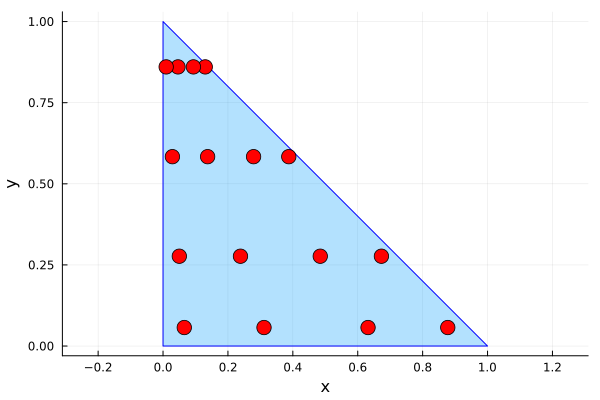

In [140]:
vertices = [
    0.0 0.0
    1.0 0.0
    0.0 1.0
]

# Need at least 4 vertices for plotting?
vertices1 = [vertices; vertices[1:1, :]]

using Plots
plot()

# for npoints in [1,2]
npoints = 4
    X, W = mysimplexquad(BigFloat, npoints, 2)

    # scene = Scene()
    # lines!(scene, vertices1; color = :black, linewidth = 2)
    # scatter!(scene, X[:, 1], X[:, 2]; color = :red, markersize = 0.3 * sqrt.(W))
    # text!(scene, "N=$npoints"; fontsize = 0.15, position = (0.5, 0.9))
    # scale!(scene, 1, 1)

    # Makie.save("figures/gauß-points-$npoints.png", scene; resolution = (300, 300))

    # x = [p1[1], p2[1], p3[1], p1[1]]
    # y = [p1[2], p2[2], p3[2], p1[2]]


    # Plot the triangle
    plot!(vertices1'[1,:], vertices1'[2,:], seriestype = :shape, fillalpha = 0.3, linecolor = :blue, legend = false, aspect_ratio = :equal)
    scatter!(X[:, 1], X[:, 2], markersize = 8, markercolor = :red, legend = false, aspect_ratio = :equal)

    # Add plot title and labels
    xlabel!("x")
    ylabel!("y")
# end

In [141]:
# Integral function using custom factorial
function integral(i, j)
    factorial(j) * factorial(i) / factorial(i + j + 2)
end

rhs(order) = vcat([integral(i, j) for i in 0:order for j in 0:order if i + j <= order]...)
rhs(2)

6-element Vector{Float64}:
 0.5
 0.16666666666666666
 0.08333333333333333
 0.16666666666666666
 0.041666666666666664
 0.08333333333333333

In [142]:
X, W = mysimplexquad(BigFloat, 10, 2)

function integral2(i, j)
    w = 0
    for k=1:length(W)
        w += W[k]*X[k,1]^i*X[k,2]^j
    end
    return w
end

# integral2(1,2)

rhs2(order) = vcat([integral2(i, j) for i in 0:order for j in 0:order if i + j <= order]...)
rhs2(5)
# rhs(5)

21-element Vector{BigFloat}:
 0.4999999999999999999999999999999999999999999999999999999999999999999999999999827
 0.1666666666666666666666666666666666666666666666666666666666666666666666666666523
 0.0833333333333333333333333333333333333333333333333333333333333333333333333333283
 0.04999999999999999999999999999999999999999999999999999999999999999999999999999471
 0.03333333333333333333333333333333333333333333333333333333333333333333333333332873
 0.0238095238095238095238095238095238095238095238095238095238095238095238095238065
 0.1666666666666666666666666666666666666666666666666666666666666666666666666666544
 0.04166666666666666666666666666666666666666666666666666666666666666666666666666523
 0.01666666666666666666666666666666666666666666666666666666666666666666666666666598
 0.008333333333333333333333333333333333333333333333333333333333333333333333333332452
 ⋮
 0.01666666666666666666666666666666666666666666666666666666666666666666666666666652
 0.005555555555555555555555555555555555555555555